# Financial Econometrics I: Homework 1

## David Černý, Jan Hrušák

## Problem 1


We decided to stick with the companies from the Consumer Discretionary Sector -> We obtain 67 symbols. (Note that some of them were further discarded due to the incompatable or missing data)

In [ ]:

symbols_data <- read.csv("symbols.csv", header = TRUE, sep = ';')


#filter the Consumer Discretionary sector
consumer_discretionary <- subset(symbols_data, Sector == 'Consumer Discretionary')

print(consumer_discretionary)

#get symbols
symbols <- consumer_discretionary$ď.żSymbol

print(symbols)
#time period
start_date <- as.Date("2015-07-01")
end_date <- as.Date("2023-12-31")


In [ ]:
#install.packages('quantmod')

In [ ]:
library('quantmod')

#'data' empty list
data <- list()


for (symbol in symbols) {
  print(symbol) #CHECK: PRINT SYMBOL BEING PROCESSED
  result <- tryCatch({
    getSymbols(symbol, auto.assign = FALSE, from = start_date, to = end_date)
  }, error = function(e) {
    cat("Error fetching data for", symbol, ": ", e$message, "\n")
    NULL #Return NULL when error
  })
  if (!is.null(result)) {
    data[[symbol]] <- result
  }
}


In [ ]:
#check if we have the desired symbols
print(names(data))

In [ ]:
#check the data
lapply(data, head)

## 1.

In [ ]:
#'lrets' and 'rets' empty lists to store log-returns and simple returns
lrets <- list()
rets <- list()

#lapply(data, head)

#loop through each symbol in data list:
for(symbol in names(data)) {
  #extract the Adjusted closing prices:
  prices <- Cl(data[[symbol]]) 
  
  #log-returns:
  log_returns <- diff(log(prices))
  lrets[[symbol]] <- log_returns
  
  #simple returns:
  simple_returns <- diff(prices) / lag(prices, k = 1)
  rets[[symbol]] <- simple_returns
}

#'lrets' and 'rets' contain the log-returns and simple returns for each stock

In [ ]:
#print(head(lrets))
lapply(lrets, head)

## 2.

We depict basic descriptive statistics (i.e. sample mean, variance, skewness, excess kurtosis, minimum and maximum of
    the series of logarithmic returns) and dispay them in the data frame.

In [ ]:
stats_list <- list()

#function to calculate skewness
calc_skewness <- function(x) {
  n <- length(x)
  mean_x <- mean(x, na.rm = TRUE)
  s <- sd(x, na.rm = TRUE)
  skewness <- (n / ((n - 1) * (n - 2))) * sum(((x - mean_x) / s)^3, na.rm = TRUE)
  return(skewness)
}

#excess kurtosis
calc_excess_kurtosis <- function(x) {
  n <- length(x)
  mean_x <- mean(x, na.rm = TRUE)
  s <- sd(x, na.rm = TRUE)
  kurtosis <- (n * (n + 1) / ((n - 1) * (n - 2) * (n - 3))) * sum(((x - mean_x) / s)^4, na.rm = TRUE) - (3 * (n - 1)^2 / ((n - 2) * (n - 3)))
  return(kurtosis)
}

#loop through each symbol in lrets
for(symbol in names(lrets)) {
  #calculate statistics:
  mean_val <- mean(lrets[[symbol]], na.rm = TRUE)
  variance_val <- var(lrets[[symbol]], na.rm = TRUE)
  skewness_val <- calc_skewness(lrets[[symbol]])
  kurtosis_val <- calc_excess_kurtosis(lrets[[symbol]])
  min_val <- min(lrets[[symbol]], na.rm = TRUE)
  max_val <- max(lrets[[symbol]], na.rm = TRUE)
  
  #store the statistics in the list:
  stats_list[[symbol]] <- c(Mean = mean_val, Variance = variance_val, Skewness = skewness_val, ExcessKurtosis = kurtosis_val, Minimum = min_val, Maximum = max_val)
}

#nicely readable format():
stats_df <- do.call(rbind, lapply(stats_list, function(x) as.data.frame(t(x))))
rownames(stats_df) <- names(stats_list)


print(stats_df)

## 3.

**Ploting**: We firstly try to plot all titles into one Figure, however the Figure might be hard to read therefore in case of further interest each symbol is then depicted individually.

In [ ]:

rws <- do.call(cbind, lrets)
options(repr.plot.width = 10, repr.plot.height = 8)

#plot the first time series to set up the plot
plot(ts(rws[, 1]), ylim = c(min(rws, na.rm = TRUE), max(rws, na.rm = TRUE)), ylab = 'Log Returns', xlab = 'Time', type = 'l')

#add the other time series
for(j in 2:ncol(rws)) {
  lines(ts(rws[, j]), col = colors()[j])
}

legend("topright", legend = names(lrets), col = colors()[2:(ncol(rws) + 1)], lty = 1)


In [ ]:
options(repr.plot.width = 12, repr.plot.height = 12)
par(mfrow = c(2, 3))
sapply(lrets, function(y){
    plot(as.Date(index(y)), y, type = 'l', xlab = 'Year',
     ylab = 'returns')
})

## 4.

**Data Cleaning**: Now we will discard symbols with problem with data validity. We take the symbol with the highest amount of observation as benchmark and if some symbol includes less than 80% observations of the benchmark we will discard it.The next step is that we construct index of log returns (mean across symbols) from all remaining symbols. Thus we obtain one time series representing such log returns index.


In [ ]:

#find the symbol with the most observations for the benchmark sample period
max_length <- max(sapply(lrets, nrow))

#fction to calculate the percentage of non-missing observations
percentage_valid_data <- function(df) {
  sum(!is.na(df)) / max_length * 100
}

#apply the function to each symbol and filter out those below the 80% threshold
valid_symbols <- sapply(lrets, function(df) percentage_valid_data(df) >= 80)

#keep only the symbols that meet the criterion
lrets_filtered <- lrets[valid_symbols]

print(lrets_filtered)
#lrets_filtered now contains only the symbols with valid data for at least 80% of the dates


In [ ]:

lrets_filtered_with_dates <- lapply(lrets_filtered, function(df) {
  if (!"date" %in% colnames(df)) { #check if 'date' column doesn't exist
    df$date <- rownames(df) 
    rownames(df) <- NULL #remove row names
  }
  df
})

#custom merge fction for two dataframes by date
merge_by_date <- function(x, y) {
  merge(x, y, by = "date", all = FALSE) #the 'all = FALSE'is an inner join
}

#Reduce applies the merge across all dataframes in the list
merged_data <- Reduce(merge_by_date, lrets_filtered_with_dates)

head(merged_data)


In [ ]:
#identify columns with names starting with 'by'
columns_to_remove <- grep("^by(\\.\\d+)?$", names(merged_data), value = TRUE)

#remove the columns from the dataframe
merged_data_cleaned <- merged_data[, !(names(merged_data) %in% columns_to_remove)]

head(merged_data_cleaned)


In [ ]:
#remove rows with any NA values
merged_data_no_nas <- na.omit(merged_data_cleaned)

head(merged_data_no_nas)


In [ ]:
#mean log return for each date, exclude the first column (date) from the computation
mean_log_returns <- rowMeans(merged_data_no_nas[,-1])

#print(mean_log_returns)

mean_log_returns_df = data.frame(index(merged_data_no_nas), mean_log_returns)

names(mean_log_returns_df) = c('date', 'mean_log_returns')

print(mean_log_returns_df)

## 5.

Since Normal/Lognormal distributions empirically seem not to describe Financial Markets returns/log_returns properly (Due to problems with heavy tails (kurtosis), skewness etc.), we will now try to fit Stable Levy distributions on our returns. On the contrary to Normal Distribution which is determined by mean and standard deviation, Stable Levy Distribution works with 4 parameters: alpha, beta, gamma, delta -> location(mean), scale(similar to std/variance), stability and skewness. With objections mentioned above the Stable Levy distribution should take into account factors (skewness, heavy-tails), which are usually problematic for Normal Distribution. Therefore we expect that the Stable Distribution could describe returns of our index better than the Normal one.

In [ ]:
#install.packages('StableEstim')

In [ ]:
library("StableEstim")


In [ ]:
returns = as.numeric(na.omit(mean_log_returns_df$mean_log_returns))


objKout = Estim(EstimMethod = "Kout", data = returns, pm = 0,
                         ComputeCov = FALSE, HandleError = FALSE,
                         spacing = "Kout")

In [ ]:
objKout@par


## 6.

In [ ]:
#plot(ret, type = "l", main = "stable: SP500",col = "steelblue")
hist(returns, n = 50, probability = TRUE, border = "white",
     col = "steelblue")
x <- seq(-0.1, 0.1, 0.001)
m <- mean(na.omit(mean_log_returns_df$mean_log_returns))
std <- sd(na.omit(mean_log_returns_df$mean_log_returns))
lines(x, dstable(x, alpha = objKout@par[1], beta = objKout@par[2], 
    gamma=objKout@par[3], delta=objKout@par[4],tol= 1e-3), lwd = 2)
lines(x, dnorm(x, mean = m, sd = std), lwd = 2, col = 'red')

In the figure it is obvious that the Stable Levy distribution (black line) catches the behaviour of our index returns much better than the Normal Distribution(red line). this is best seen in outliers (either excess returns or excess loss), where such events are indicated by the normal distribution as practically impossible, while the stable levy distribution takes them into account.

## Problem 2

## 1. 

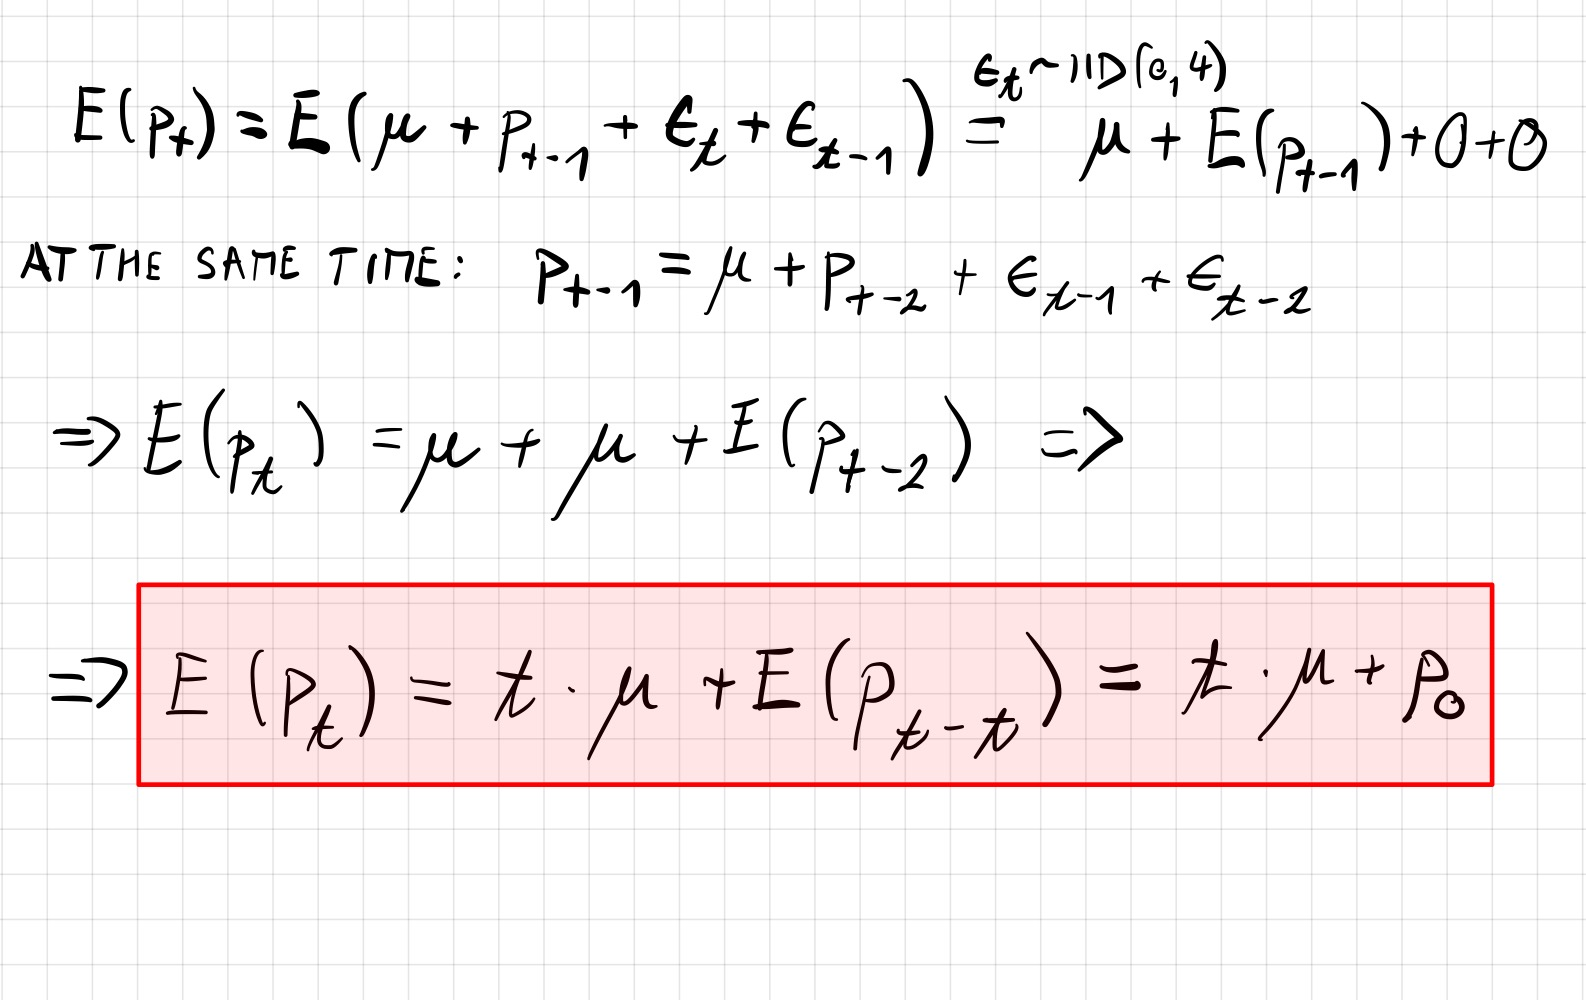

The process pt is not mean stationary since its expected value changes with time t.

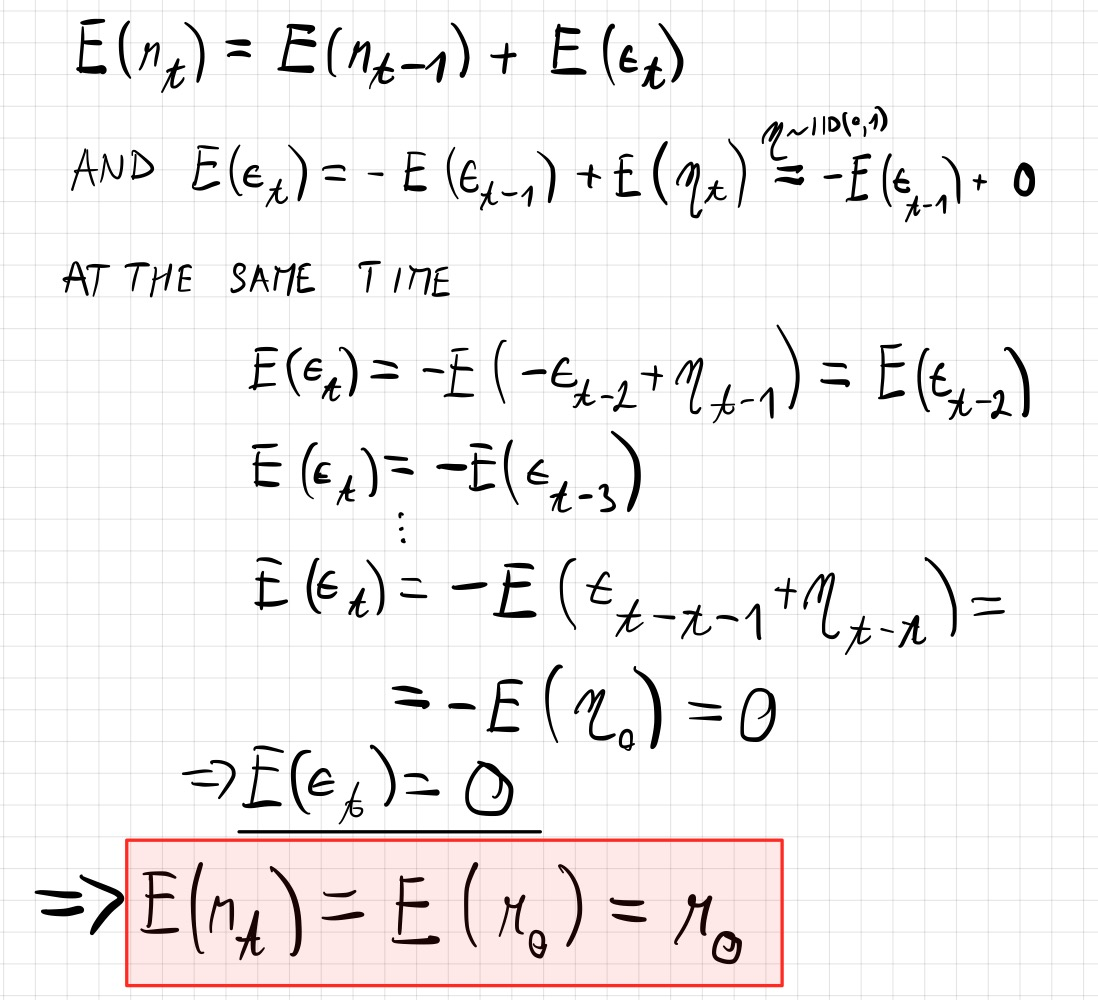

The process rt is mean stationary since its expected value does not change over time.

Next, we calculate variance:

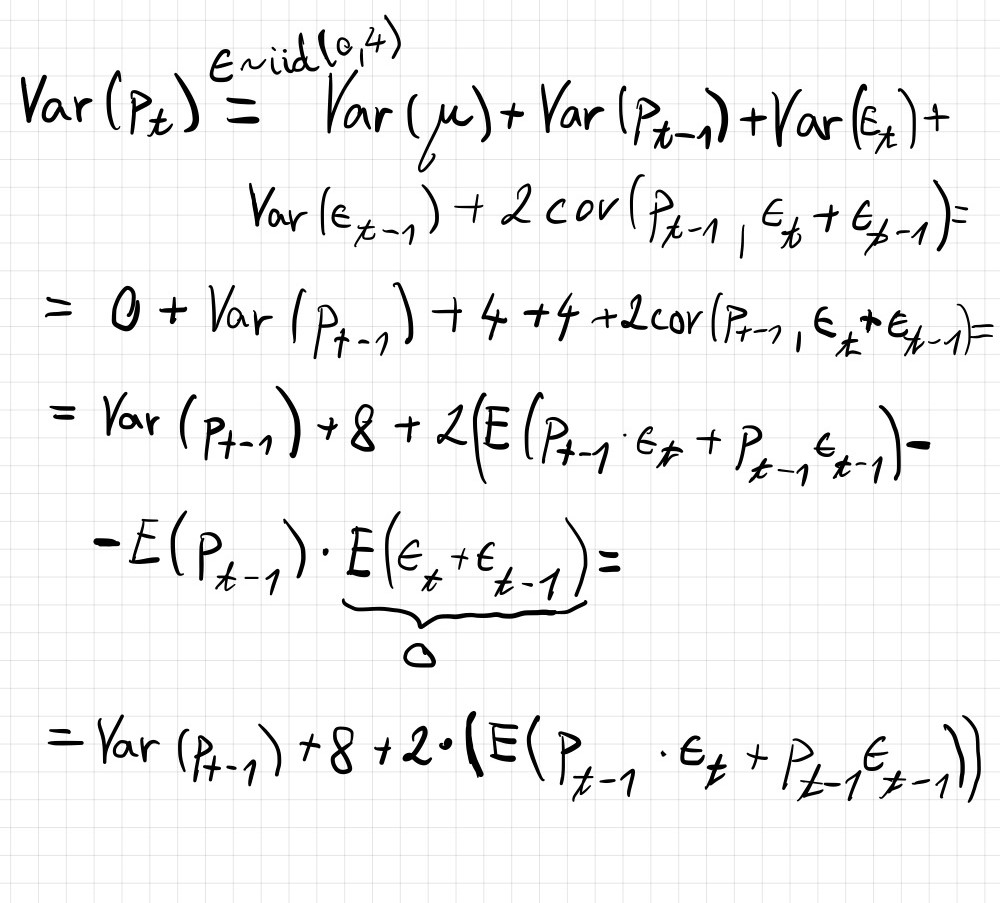

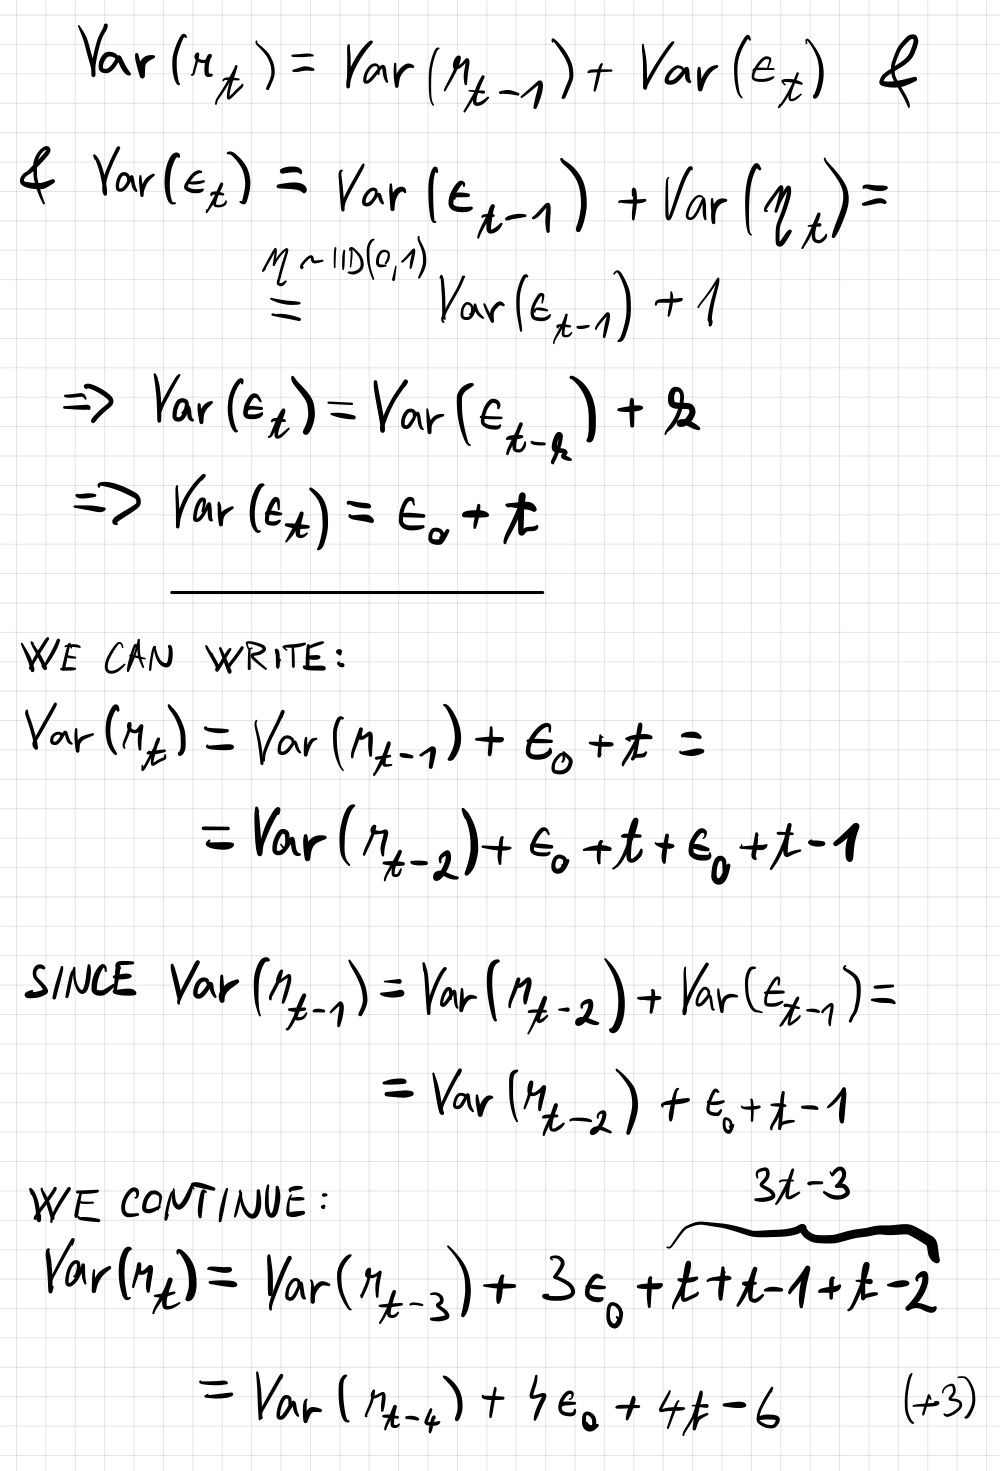

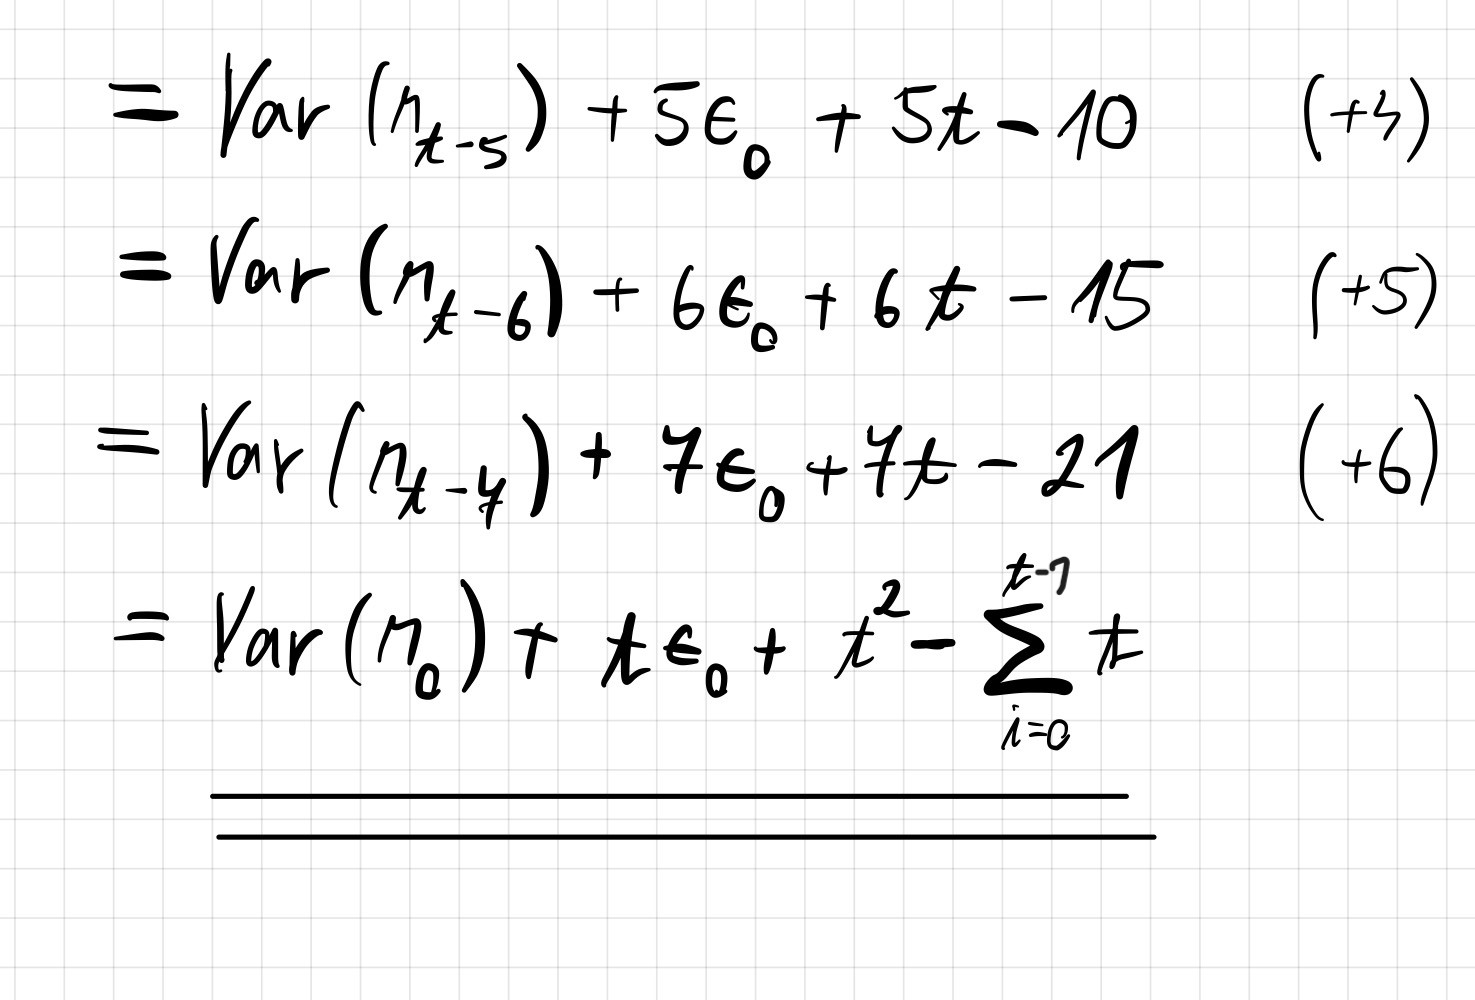

The processs rt is not variance stationary since it is dependent on the value of t.

## 2.

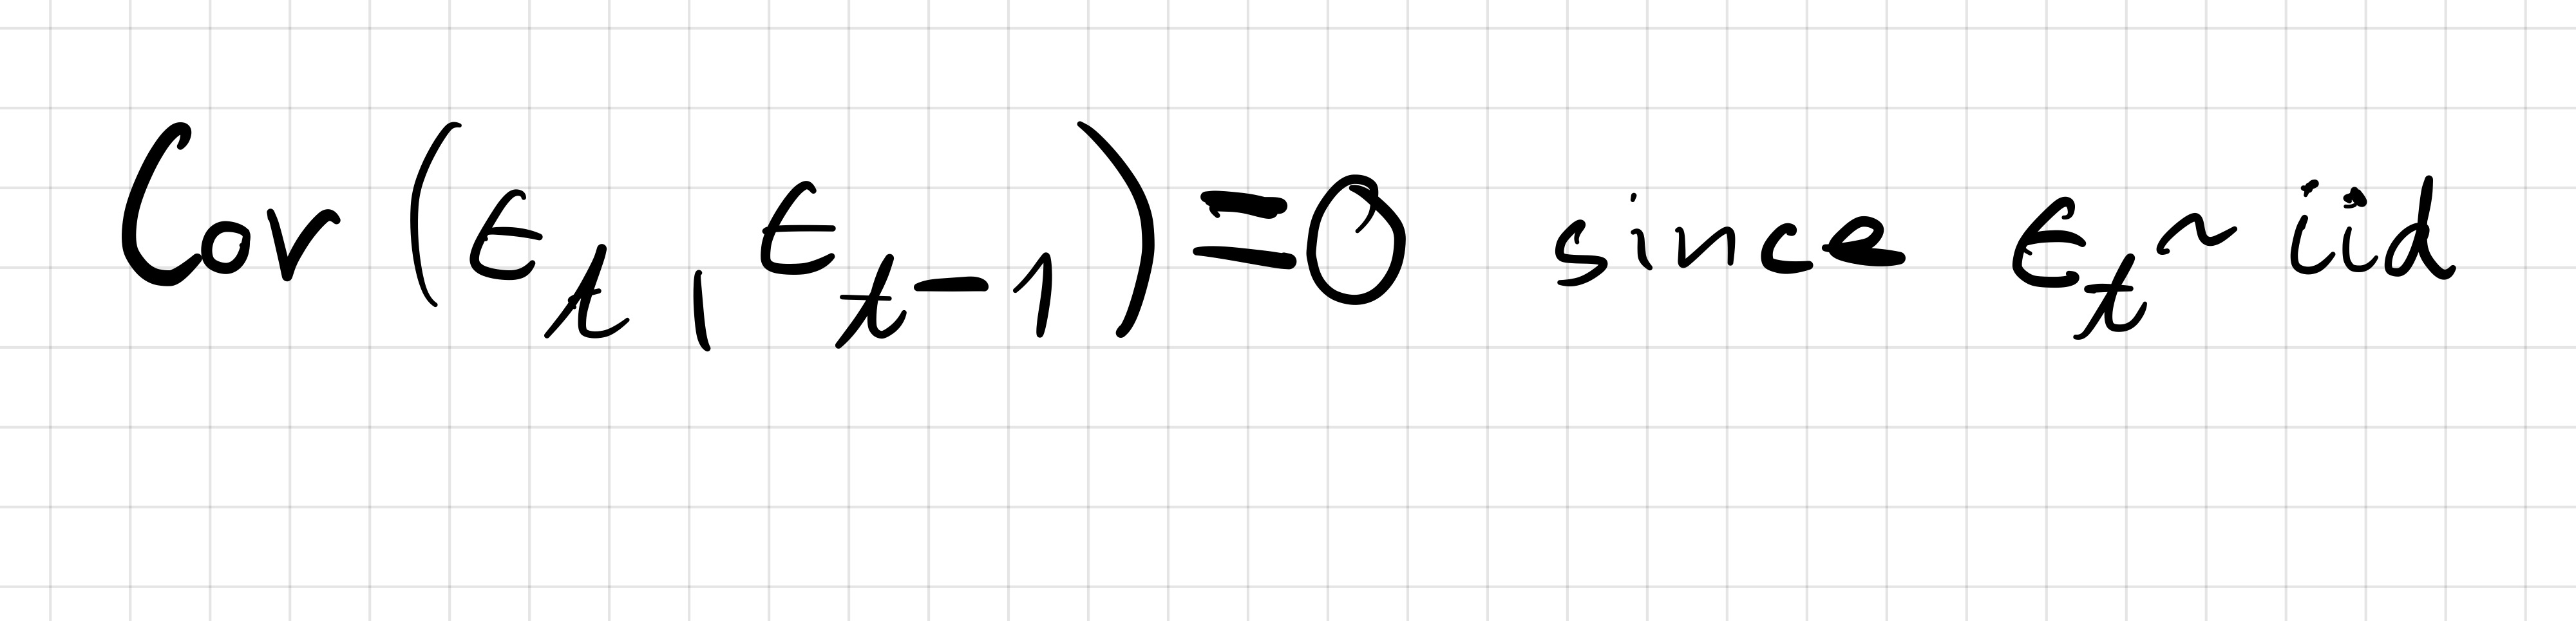

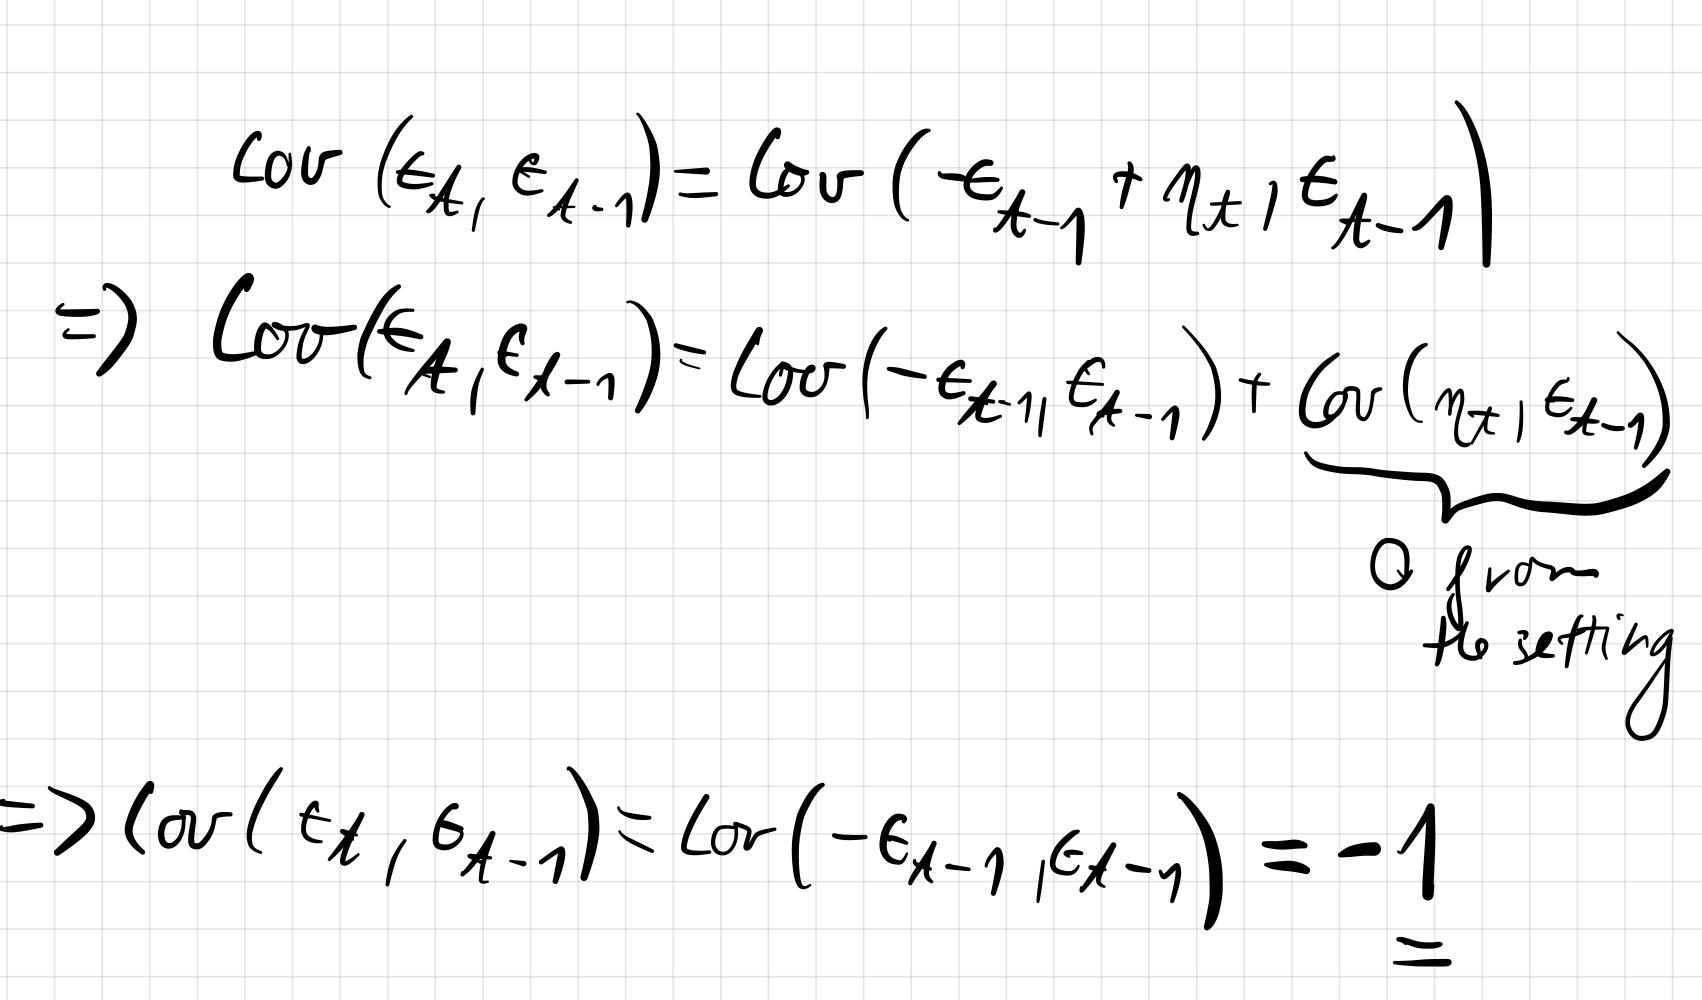

## 3.

In [ ]:
set.seed(50)

#parameters
T <- 500   #time steps
N <- 1000  #realizations
mu <- 0.2
p0 <- r0 <- 15
epsilon_0 <- 0

#matrices to store the simulations
pt_simulations <- matrix(0, nrow = N, ncol = T)
rt_simulations <- matrix(0, nrow = N, ncol = T)

for (i in 1:N) {
  pt <- rep(0, T)
  rt <- rep(0, T)
  pt[1] <- p0
  rt[1] <- r0
  
  
  epsilon2 <- rep(0, T)

  eta <- rnorm(T, mean = 0, sd = 1)

  epsilon1 <- rnorm(T, mean = 0, sd = 2)


  epsilon1[1] <- epsilon_0
  epsilon2[1] <- epsilon_0

  for (t in 2:T) {
    #update epsilon for process 2

    
    epsilon2[t] <- -epsilon2[t-1] + eta[t]


    
    #process 1
    pt[t] <- mu + pt[t-1] + epsilon1[t] + epsilon1[t-1]
    
    #process 2
    rt[t] <- rt[t-1] + epsilon2[t]
  }
  
  #store the simulation
  pt_simulations[i, ] <- pt
  rt_simulations[i, ] <- rt
}

#first 10 steps of the first simulation of pt and rt)
pt_simulations_example <- pt_simulations[1, 1:10]
rt_simulations_example <- rt_simulations[1, 1:10]

print(pt_simulations_example)
print(rt_simulations_example)


In [ ]:
#process pt
plot(pt_simulations[1, ], type = 'l', col = 'blue', xlab = 'Time', ylab = 'Value', main = 'Process pt')

legend("topright", legend=c("pt"), col=c("blue"), lty=1, cex=0.8)

#process rt
plot(rt_simulations[1, ], type = 'l', col = 'red', xlab = 'Time', ylab = 'Value', main = 'Process rt')

legend("topright", legend=c("rt"), col=c("red"), lty=1, cex=0.8)


In [ ]:

#plot the first time series to set up the plot
#plot(ts(rws[, 1]), ylim = c(min(rws, na.rm = TRUE), max(rws, na.rm = TRUE)), ylab = 'Log Returns', xlab = 'Time', type = 'l')

plot(ts(pt_simulations[1, ]), ylim = c(min(pt_simulations, na.rm = TRUE), max(pt_simulations, na.rm = TRUE)), type = 'l', col = 'blue', xlab = 'Time', ylab = 'Value', main = 'Process pt')



#add the other time series
for(j in 2:nrow(pt_simulations)) {
  lines(ts(pt_simulations[j, ]), col = colors()[j])
}

#legend("topright", legend = names(pt_simulations), col = colors()[2:(nrow(pt_simulations) + 1)], lty = 1)





In [ ]:
plot(ts(rt_simulations[1, ]), ylim = c(min(rt_simulations, na.rm = TRUE), max(rt_simulations, na.rm = TRUE)), type = 'l', col = 'blue', xlab = 'Time', ylab = 'Value', main = 'Process rt')



#add the other time series
for(j in 2:nrow(rt_simulations)) {
  lines(ts(rt_simulations[j, ]), col = colors()[j])
}

#legend("topright", legend = names(rt_simulations), col = colors()[2:(nrow(rt_simulations) + 1)], lty = 1)


In [ ]:
#parameters
mu <- 0.2
p0 <- r0 <- 15

#E(p200) and E(r400)
E_p200 <- p0 + 200 * mu
E_r400 <- r0  #since the expected change in r_t is 0 at each step

cat("E(p200) =", E_p200, "\n")
cat("E(r400) =", E_r400, "\n")


In [ ]:
#check empirically (with the generated matrices)


mean(pt_simulations[,200])
mean(rt_simulations[,400])